In [105]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from plot import plot_histogram, \
      plot_hist_by_phenotype, plot_triadic_pattern_phenotype, plot_bar_diadic_pattern, \
      plot_xhi_by_phenotype, plot_diadic_pattern
from analysis import histogram, measure_global, compute_xhi, compute_xhi_mean, compute_all_xhi_mean
from graph import Network
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from dataset import Dataset, measure_frequency_diadic_pattern, measure_global_frequency_triadic_pattern
import os

import pymc as pm
import arviz as az

In [106]:
file = r"../out/size_effect_sith/SITH_E3O2P21R12T17_Empty_L10_C750_S30_T0.25_157905.h5"
net = Network()
net.reload_with_hdf5(file)

parameters = net.parameters
inter = parameters["Number of interaction"]
n = parameters["Community size"]

name = net.name
os.makedirs("../plot/Size_effect/"  + str(n) + "/", exist_ok=True)

In [107]:
t, l = net.get_trust_adjacency_matrix(), net.get_link_adjacency_matrix()
print("Number of interaction: ", inter)
print("Asymmetry rate: ", measure_global("Asymmetry", t, l, parameters))
print("Individual asymmetry rate: ", measure_global("Individual asymmetry", t, l, parameters))
print("Out preserving ind. asymmetry: ", measure_global("Individual asymmetry", t, l, parameters, random=True, niter=1000, mode="o"))
print("Saturation rate: ", measure_global("Saturation rate", t, l, parameters))
link_stat = measure_global("Number of link", t, l, parameters)
print("Mean number of link per agent: ", link_stat[0])
print("Standard deviation number of link per agent: ", link_stat[1])
print("Mean number of interaction per link: ", 2 * inter / (n * (n-1)))

Number of interaction:  157905
Asymmetry rate:  0.3442622950819672
Individual asymmetry rate:  0.2
Out preserving ind. asymmetry:  0.4666666666666667
Saturation rate:  0.8
Mean number of link per agent:  16.833333333333332
Standard deviation number of link per agent:  19.291621670213907
Mean number of interaction per link:  363.0


In [108]:
local_dt = Dataset("local", inter)
local_dt.init_with_network(net)

### Trust distribution

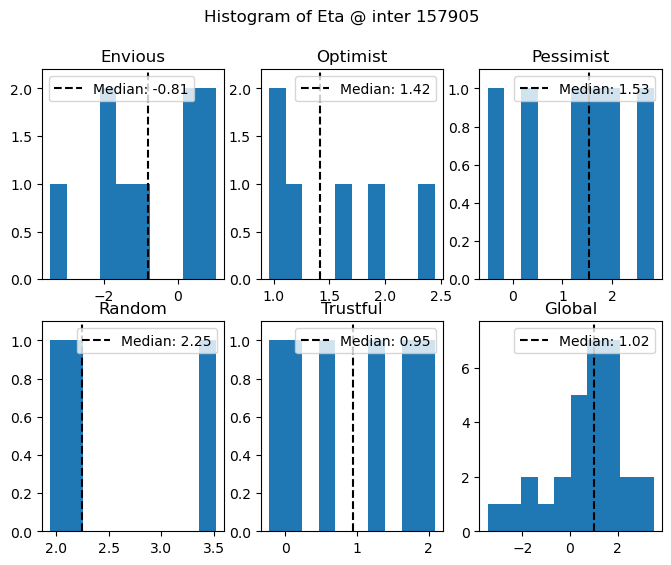

In [109]:
plot_hist_by_phenotype(local_dt, "Eta")
plt.savefig("../plot/Size_effect/"  + str(n) + "/eta_histograms.png")
#plt.show()

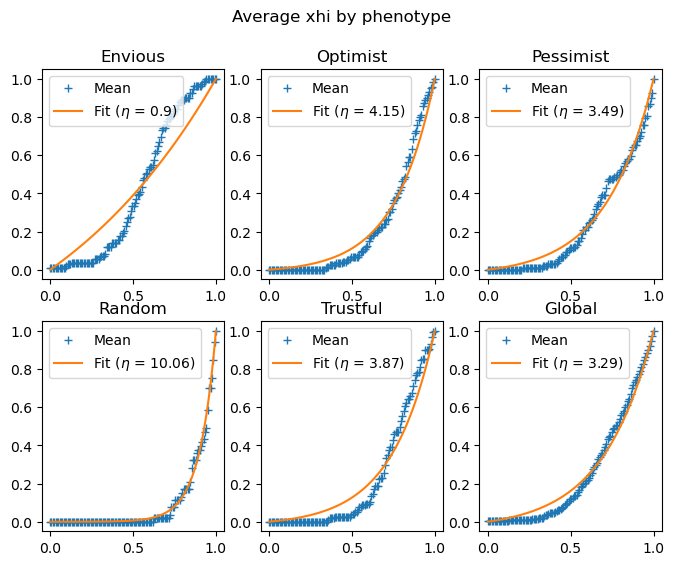

In [110]:
all_xhi = compute_all_xhi_mean(t, parameters)
plot_xhi_by_phenotype(all_xhi)
plt.savefig("../plot/Size_effect/"  + str(n) + "/average_xhi_by_phenotype.png")
#plt.show()

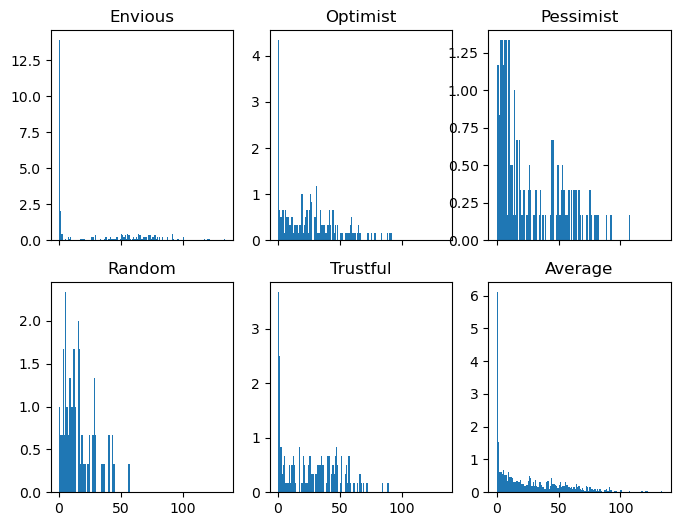

In [111]:
ph_mean = histogram(t, parameters)
fig, ax = plot_histogram(ph_mean, parameters, log=False, color="tab:blue")
plt.show()

### Centrality

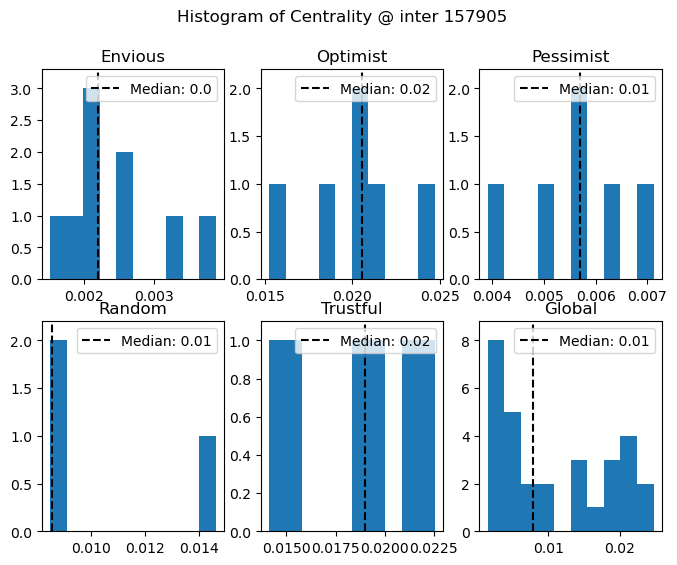

In [112]:
plot_hist_by_phenotype(local_dt, "Centrality")
plt.savefig("../plot/Size_effect/"  + str(n) + "/Centrality histograms.png")
#plt.show()

### Diadic pattern

In [113]:
di_pattern_freq = measure_frequency_diadic_pattern(l, net.phenotypes_table, inter)

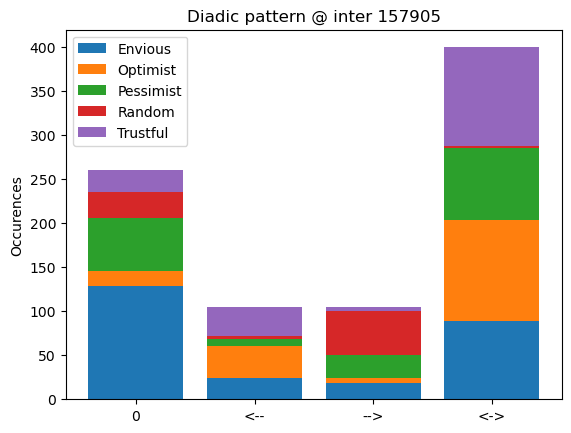

In [114]:
plot_bar_diadic_pattern(di_pattern_freq)
plt.savefig("../plot/Size_effect/"  + str(n) + "/diadic_pattern_bar.png")
#plt.show()

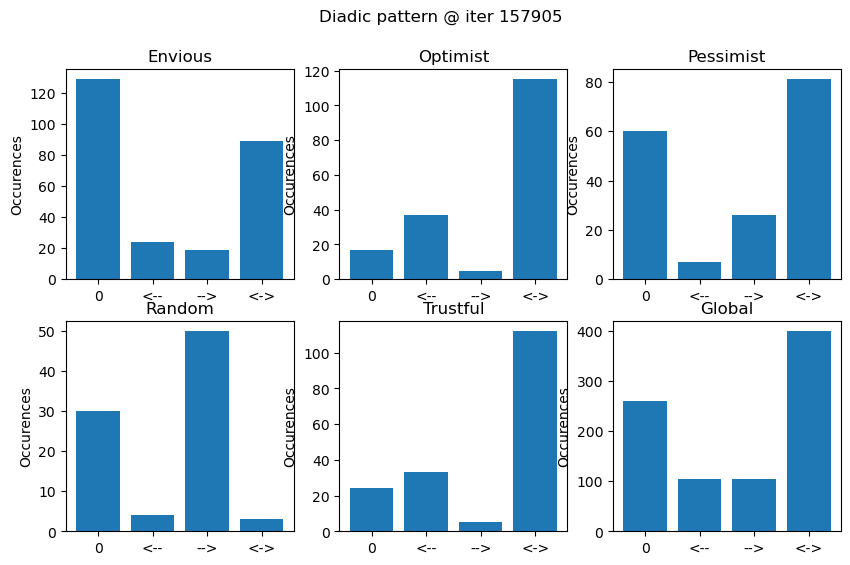

In [115]:
plot_diadic_pattern(di_pattern_freq)
plt.show()

### Triadic pattern

In [116]:
tri_pattern_freq = measure_global_frequency_triadic_pattern(l.astype(int), parameters, inter)

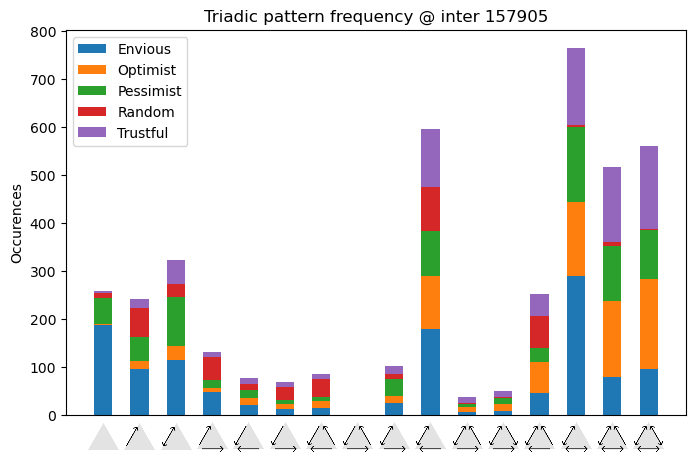

In [117]:
plot_triadic_pattern_phenotype(tri_pattern_freq, parameters)
plt.savefig("../plot/Size_effect/"  + str(n) + "/triadic_pattern_bar.png")
#plt.show()

In [118]:
dtga = tri_pattern_freq.group_by("Transitive").aggregate("Number")
data = dtga.get_item(True).get_item("Number").get_all_item().values()
transitivity_rate = sum(data) / (n * (n-1) * (n-2) / 6)
print("Transitiviy rate: ", transitivity_rate)

Transitiviy rate:  0.3694581280788177


### Bayesian stuff

Estimated eta:  6.419239786766595


<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_1440\2716832538.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


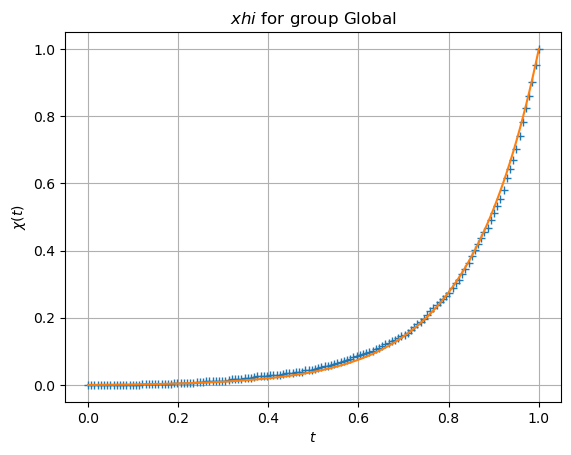

In [8]:
selector = "Global"
xhi_mean = compute_xhi_mean(t, parameters, ph_selector=selector)
size = xhi_mean.size
t_norm = np.arange(size)/(size-1)
model = lambda i, eta:  (np.exp(eta * i) - 1) / (np.exp(eta) - 1)
popt, copt = curve_fit(model, t_norm, xhi_mean)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi_mean, "+", label="data")
plt.plot(t_norm, model(t_norm, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for group {}".format(selector))
plt.grid()
plt.show()

In [12]:
xhi_mean = compute_xhi_mean(t, parameters)
size = xhi_mean.size
t_norm = np.arange(size) / (size-1)
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    etas = pm.Normal("etas", mu=2.5, sigma=4)

    # Likelihood
    likelihood = pm.Normal("xhi mean", mu= (np.exp(etas * t_norm) - 1) / (np.exp(etas) - 1), sigma=sigma, observed=xhi_mean)

    # Inference
    idata = pm.sample(3000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, etas]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
etas,9.919,0.083,9.756,10.070,0.001,0.001,12288.0,8707.0,1.0
sigma,0.018,0.001,0.016,0.019,0.000,0.000,12043.0,8707.0,1.0


In [14]:
pp = pm.sample_posterior_predictive(idata, model, progressbar=False)
idata.extend(pp)

Sampling: [xhi mean]


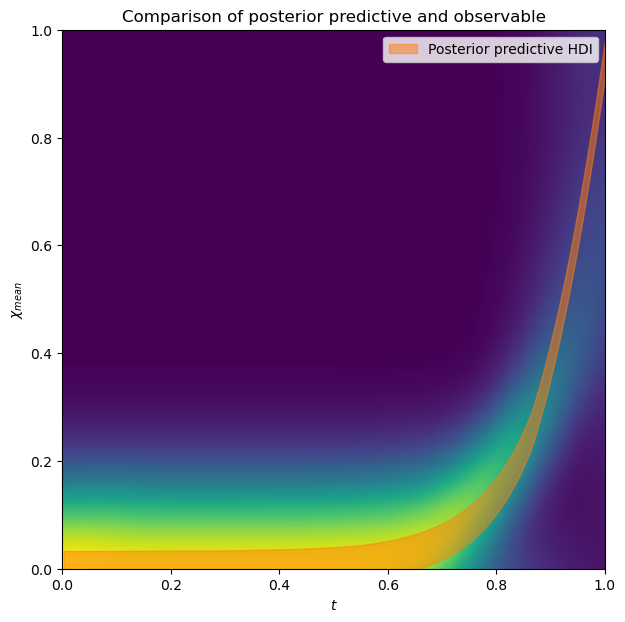

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
az.plot_kde(t_norm, xhi_mean, contour=False, ax=ax, label="Observed data KDE", fill_kwargs={"alpha": 0.1})
az.plot_hdi(t_norm, idata.posterior_predictive["xhi mean"], fill_kwargs={"label": "Posterior predictive HDI"})
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xlabel("$t$")
ax.set_ylabel("$\\chi_{mean}$")
ax.set_title("Comparison of posterior predictive and observable")
plt.legend()
plt.show()